In [1]:
#### LIBRARIES AND FUNCTIONS
using Plots
using JLD2
using Statistics
using Random
using StatsBase
using Integrals
using GenericSchur
using LaTeXStrings
using Pkg
using Combinatorics
using LinearAlgebra
using Base.Threads
using DSP

function ArnoldMap_Integrate(xin,p)
    ν,σ,M,tr = p
    x0 , y0 = xin
    X = zeros(M+tr,2) # EDITED
    A = ones(2,2); A[1,1] = 2
    α = angle(ν) ; μ = abs(ν)
    Xold = xin;
    for it in 1:M+tr
        sum = Xold[1] + Xold[2]
        num = μ*sin(2*π*sum - α)
        den = 1 - μ*cos(2*π*sum - α)

        map = mod.( A*Xold .+ 1/ π *atan(num/den) .+ σ*randn(2) , 1 )

        X[it,:] = map # EDITED
        Xold = map
    end
    return X[1+tr:end,:] # EDITED
end


function Fourier_Dictionary!(Ψ,x,comb_mixed,comb_diag)
    for (i,c) in enumerate(comb_mixed) # The non diagonal ones
        Ψ[i] = exp(2*π*1im*dot(c,x))
    end
    for (i,c) in enumerate(comb_diag) # The diagonal ones
        Ψ[length(comb_mixed)+i] = exp(2*π*1im*c[1]*sum(x))
    end
end


function eDMD_parallel(x,Dictionary!,N,nthreads) 

    chunks = map( Iterators.partition(axes(x,1),size(x)[1] ÷ nthreads) ) do rows x[rows,:] end # EDITED
    tasks = map(chunks) do chunk
        Threads.@spawn get_GA(chunk,Dictionary!,N)
    end

    data = fetch.(tasks);
    
    G = zeros(ComplexF64,N,N)
    A = zeros(ComplexF64,N,N)
    Ltot = sum(y[3] for y in data)
    
    for y in data
        g,a,l = y    
        G .+= g .* (l/Ltot)  
        A .+= a .* (l/Ltot)
    end

    K = pinv(G)*A;
    return G,K
end

function get_GA(x,Dictionary!,N)
    # Matrices where we are gonna sum
    A = zeros(ComplexF64,N,N) ; G = zeros(ComplexF64,N,N)
    # Temporary variables for the loop evaluation
    Ψx = zeros(ComplexF64,N) ; Ψy = zeros(ComplexF64,N)
    l = size(x)[1] - 1 # Length of the trajectory  # EDITED

    for i in 1:l
        Dictionary!(Ψx,x[i,:]) # EDITED
        Dictionary!(Ψy,x[i+1,:]) # EDITED   
        G  .+= Ψx' .* Ψx ./ l 
        A  .+= Ψx' .* Ψy ./ l 
    end

    return transpose(G),transpose(A),l 
end


function spect_properties(K) # Same as 1D map

    S = schur(K);
    λ = S.values;
    Ξ = eigvecs(S);
    W = eigvecs(S,left=true);
    r = sortperm(λ,by=abs,rev=true) ; 
    
    λ = λ[r]; Ξ = Ξ[:,r]; W = W[:,r];
    normalisation = diag( W'*Ξ )
    L = W'; 
    for i in 1:size(L)[2]
         L[i,:] = L[i,:] / normalisation[i]
    end
    W = L';
    return λ,Ξ,W

end

function spectral_der(hNum,comb_mixed,comb_diag)
    hX = zeros(ComplexF64,length(hNum))
    hY = zeros(ComplexF64,length(hNum))

    for (i,value) in enumerate(comb_mixed)
        hX[i] = 2*π * 1im * value[1] * hNum[i]
        hY[i] = 2*π * 1im * value[2] * hNum[i]
    end

    for (i,value) in enumerate(comb_diag)
        index = length(comb_mixed)+ i
        hX[index] = 2*π * 1im * value[1] * hNum[index]
        hY[index] = 2*π * 1im * value[1] * hNum[index]
    end

    return hX, hY
end


function get_Leb_scalar_prod(comb_mixed,comb_diag,N)
    δ_leb = zeros(N,N)
    for (i,ki) in enumerate(comb_mixed)
        for (j,kj) in enumerate(comb_mixed)
            if(ki == kj)
                δ_leb[i,j] = 1
            end
        end
    end
    for (i,ki) in enumerate(comb_diag)
        for (j,kj) in enumerate(comb_diag)
            if(ki == kj)
                δ_leb[i+length(comb_mixed),j+length(comb_mixed)] = 1
            end
        end
    end

    return δ_leb 
end

# function get_correlation_functions_eigs(n_time,selected)
#     ψ_trial = zeros(ComplexF64,N)
    
#     Cov = zeros(Float64,length(selected),length(n_time))
    
#     for (i,value) in enumerate(selected)
#         eigenvector = Ξ[:,value]
#         Φ_traj = zeros(ComplexF64,size(X)[1])
#         for tt in 1:size(X)[1]
#             F_dict!(ψ_trial,X[tt,:])
#             Φ_traj[tt] = dot(conj(ψ_trial),eigenvector) # dot in Julia conjugate the first argument
#         end
#         Cov[i,:] = autocov(real.(Φ_traj),n_time;demean=true) + autocov(imag.(Φ_traj),n_time;demean=true)
#     end
#     return Cov
# end
    
function proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag)
    L = length(comb_mixed) + length(comb_diag)
    h = zeros(ComplexF64,L)
    domain = ( zeros(2) , ones(2) ) # (lb, ub)

    for (i,c) in enumerate(comb_mixed) # The non diagonal ones
        g(u) = exp(2*π*1im*dot(c,u))
        f(u, p) = obs(u)* conj(g(u))
        prob = IntegralProblem(f, domain)
        sol = solve(prob, HCubatureJL(); reltol = 1e-3, abstol = 1e-3)
        h[i] = sol.u
    end

    for (i,c) in enumerate(comb_diag) # The diagonal ones
        g(u) = exp(2*π*1im*c[1]*sum(u))
        f(u, p) = obs(u)* conj(g(u))
        prob = IntegralProblem(f, domain)
        sol = solve(prob, HCubatureJL(); reltol = 1e-3, abstol = 1e-3)
        h[length(comb_mixed)+i] = sol.u
    end


    return h;
end

function proj_dictionary_numerical_Fourier(obs,comb_mixed,comb_diag,xgrid,ygrid)
    L = length(comb_mixed) + length(comb_diag)
    h = zeros(ComplexF64,L)
    domain = ( zeros(2) , ones(2) ) # (lb, ub)
    method = SimpsonsRule()
    dict = zeros(ComplexF64,length(xgrid),length(ygrid))

    for (i,c) in enumerate(comb_mixed) # The non diagonal ones
    
        for (ii,vX) in enumerate(xgrid)
            for (jj,vY) in enumerate(ygrid)
                x = [xgrid[ii],ygrid[jj]]
                dict[ii,jj] = conj( exp(2*π*1im*dot(c,x)) )
            end
        end
        
        problem = SampledIntegralProblem(obs .* dict,ygrid;dim=2)
        intermediate = solve(problem,method).u
        problem = SampledIntegralProblem(intermediate,xp)
        h[i] = solve(problem,method).u
 
    end

    for (i,c) in enumerate(comb_diag) # The diagonal ones
        for (ii,vX) in enumerate(xgrid)
            for (jj,vY) in enumerate(ygrid)
                x = [xgrid[ii],ygrid[jj]]
                dict[ii,jj] = conj( exp(2*π*1im*c[1]*sum(x)) )
            end
        end
        
        problem = SampledIntegralProblem(obs .* dict,ygrid;dim=2)
        intermediate = solve(problem,method).u
        problem = SampledIntegralProblem(intermediate,xp)
        h[length(comb_mixed)+i] = solve(problem,method).u
    end


    return h;
end


function reconstruct(xgrid,ygrid,h,comb_mixed,comb_diag)
    recObs = zeros(ComplexF64,length(xgrid),length(ygrid))
    for i in 1:length(xgrid)
        for j in 1:length(ygrid)
            x = [xgrid[i],ygrid[j]]
            recObs[i,j] = rec_grid_point(x,h,comb_mixed,comb_diag)
        end
    end

    return recObs
end

function Spectral_Corr(v1,v2,λ,Δ,t,removed)
    sum = zeros(ComplexF64,1); 
    
    for k in 2:length(v1)-removed
        for l in 2:length(v2)-removed
            sum[1] = sum[1] + v1[k]*λ[k].^t*conj(v2[l])*Δ[l,k]
        end
    end
    return sum[1]
end

function rec_grid_point(u,h,comb_mixed,comb_diag)
    
    rec = zeros(ComplexF64,1)
    for (i,c) in enumerate(comb_mixed) # The non diagonal ones
       rec[1] +=  h[i]*exp(2*π*1im*dot(c,u))
    end

    for (i,c) in enumerate(comb_diag) # The diagonal ones
        rec[1] = rec[1] +  h[length(comb_mixed)+i] * exp(2*π*1im*c[1]*sum(u))
        
    end
    return rec[1]
end


function get_correlation_functions_eigs(n_time,selected,Ξ,X)
    ψ_trial = zeros(ComplexF64,N)
    
    Cov = zeros(Float64,length(selected),length(n_time))
    
    for (i,value) in enumerate(selected)
        eigenvector = Ξ[:,value]
        Φ_traj = zeros(ComplexF64,size(X)[1])
        for tt in 1:size(X)[1]
            F_dict!(ψ_trial,X[tt,:])
            Φ_traj[tt] = dot(conj(ψ_trial),eigenvector) # dot in Julia conjugate the first argument
        end
        Cov[i,:] = autocov(real.(Φ_traj),n_time;demean=true) + autocov(imag.(Φ_traj),n_time;demean=true)
    end
    return Cov
end



# function evaluate_on_grid(xgrid,ygrid,F)
#     Fnum = zeros(length(xgrid),length(ygrid))
#     for i in 1:length(xgrid)
#         for j in 1:length(ygrid)
#             point = [xgrid[i],ygrid[i]]
#             Fnum[i,j] = F(point)
#         end
#     end
#     return Fnum 
# end

get_correlation_functions_eigs (generic function with 1 method)

In [147]:
M = 2*10^6; 
tr = 500
ν = 0.88*exp(1im*(0.7419+pi))
σ = 0.01

p = (ν,σ,M,tr)
x0 = [0.3,0.2];

In [148]:
X = ArnoldMap_Integrate(x0,p);

In [149]:
K_max = 8
K_vectors = - K_max:K_max # one dimensional

# Get the dictionary wave-vectors
comb_mixed = permutations(K_vectors,2)
comb_diag = permutations(K_vectors,1)
N = length(comb_mixed) + length(comb_diag)
F_dict!(ψ,x) = Fourier_Dictionary!(ψ,x,comb_mixed,comb_diag) 
#F_dict(x) = Fourier_Dictionary(x,comb_mixed,comb_diag) 

F_dict! (generic function with 1 method)

In [150]:
# Data = JLD2.load("Spectral_Properties_wNoise.jld2")
# G = Data["G"]
# K = Data["K"];
nthreads = Threads.nthreads()
G,K = eDMD_parallel(X,F_dict!,N,nthreads);

In [151]:
λ,Ξ,W = spect_properties(K);
Δ = Ξ'*G*Ξ ;

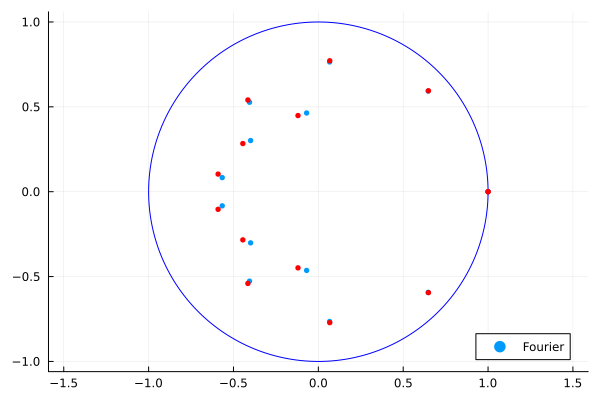

In [152]:
to_show = 1:13
lambdas = (- ν).^(0:6);
scatter(real(λ[to_show]),imag(λ[to_show]),markershape=:circle,aspect_ratio = :equal,label="Fourier",markersize=3,markerstrokewidth=0)
thetas = 0:0.01:2*π
plot!(cos.(thetas),sin.(thetas),color=:blue,label="")
#xlims!(-1,1.02)
#ylims!(-1,1)
scatter!(real(lambdas),imag(lambdas),markershape=:circle,color=:red,markersize=3,markerstrokewidth=0,label="")
scatter!(real(lambdas),-imag(lambdas),markershape=:circle,color=:red,markersize=3,markerstrokewidth=0,label="")

##  Correlation Functions

#### Correlation functions of the K-eigenfunctions

In [153]:
# selected = [2,4,6,8,10]; n_time = 0:50
# Cov = get_correlation_functions_eigs(n_time,selected,Ξ,X);

In [154]:
# Aplot = plot()
# colors = palette(:tab10)
# for (i,value) in enumerate(selected[1:2])
#     plot!(n_time,Cov[i,:]./Cov[i,1],label= L"\varphi_{%$ value}",linestyle=:dash,linewidth=0.5,color=colors[i]) 
#     scatter!(n_time,Cov[i,:]./Cov[i,1],label= "",marker=:x,markersize=5,color=colors[i]) 
#     scatter!(n_time,real( λ[value].^(n_time)),markershape=:circle,markersize=3,markerstrokewidth=0,color=colors[i],label="")
# end

# xlabel!(L"t",xguidefontsize=18)
# ylabel!(L"C_{\varphi}(t)",yguidefontsize=18)
# xlims!(-0.2,35)
# ylims!(-0.8,1.2)

# Bplot = plot()
# for (i,value) in enumerate(selected[3:end])
#     plot!(n_time,Cov[i+2,:]./Cov[i+2,1],label= L"\varphi_{%$ value}",linestyle=:dash,linewidth=0.5,color=colors[i+2]) 
#     scatter!(n_time,Cov[i+2,:]./Cov[i+2,1],label= "",marker=:x,markersize=5,color=colors[i+2]) 
#     scatter!(n_time,real( λ[value].^(n_time)),markershape=:circle,markersize=3,markerstrokewidth=0,color=colors[i+2],label="")
# end
# xlabel!(L"t",xguidefontsize=18)
# ylabel!(L"C_{\varphi}(t)",yguidefontsize=18)
# xlims!(-0.2,12)
# ylims!(-0.8,1.2)
# xticks!(0:2:12)

# plot(Aplot,Bplot,dpi=600,layout= @layout [a;b])
# #savefig("Decay_Eigenfunctions_2Dmap.png")

#### Correlations of generic observables

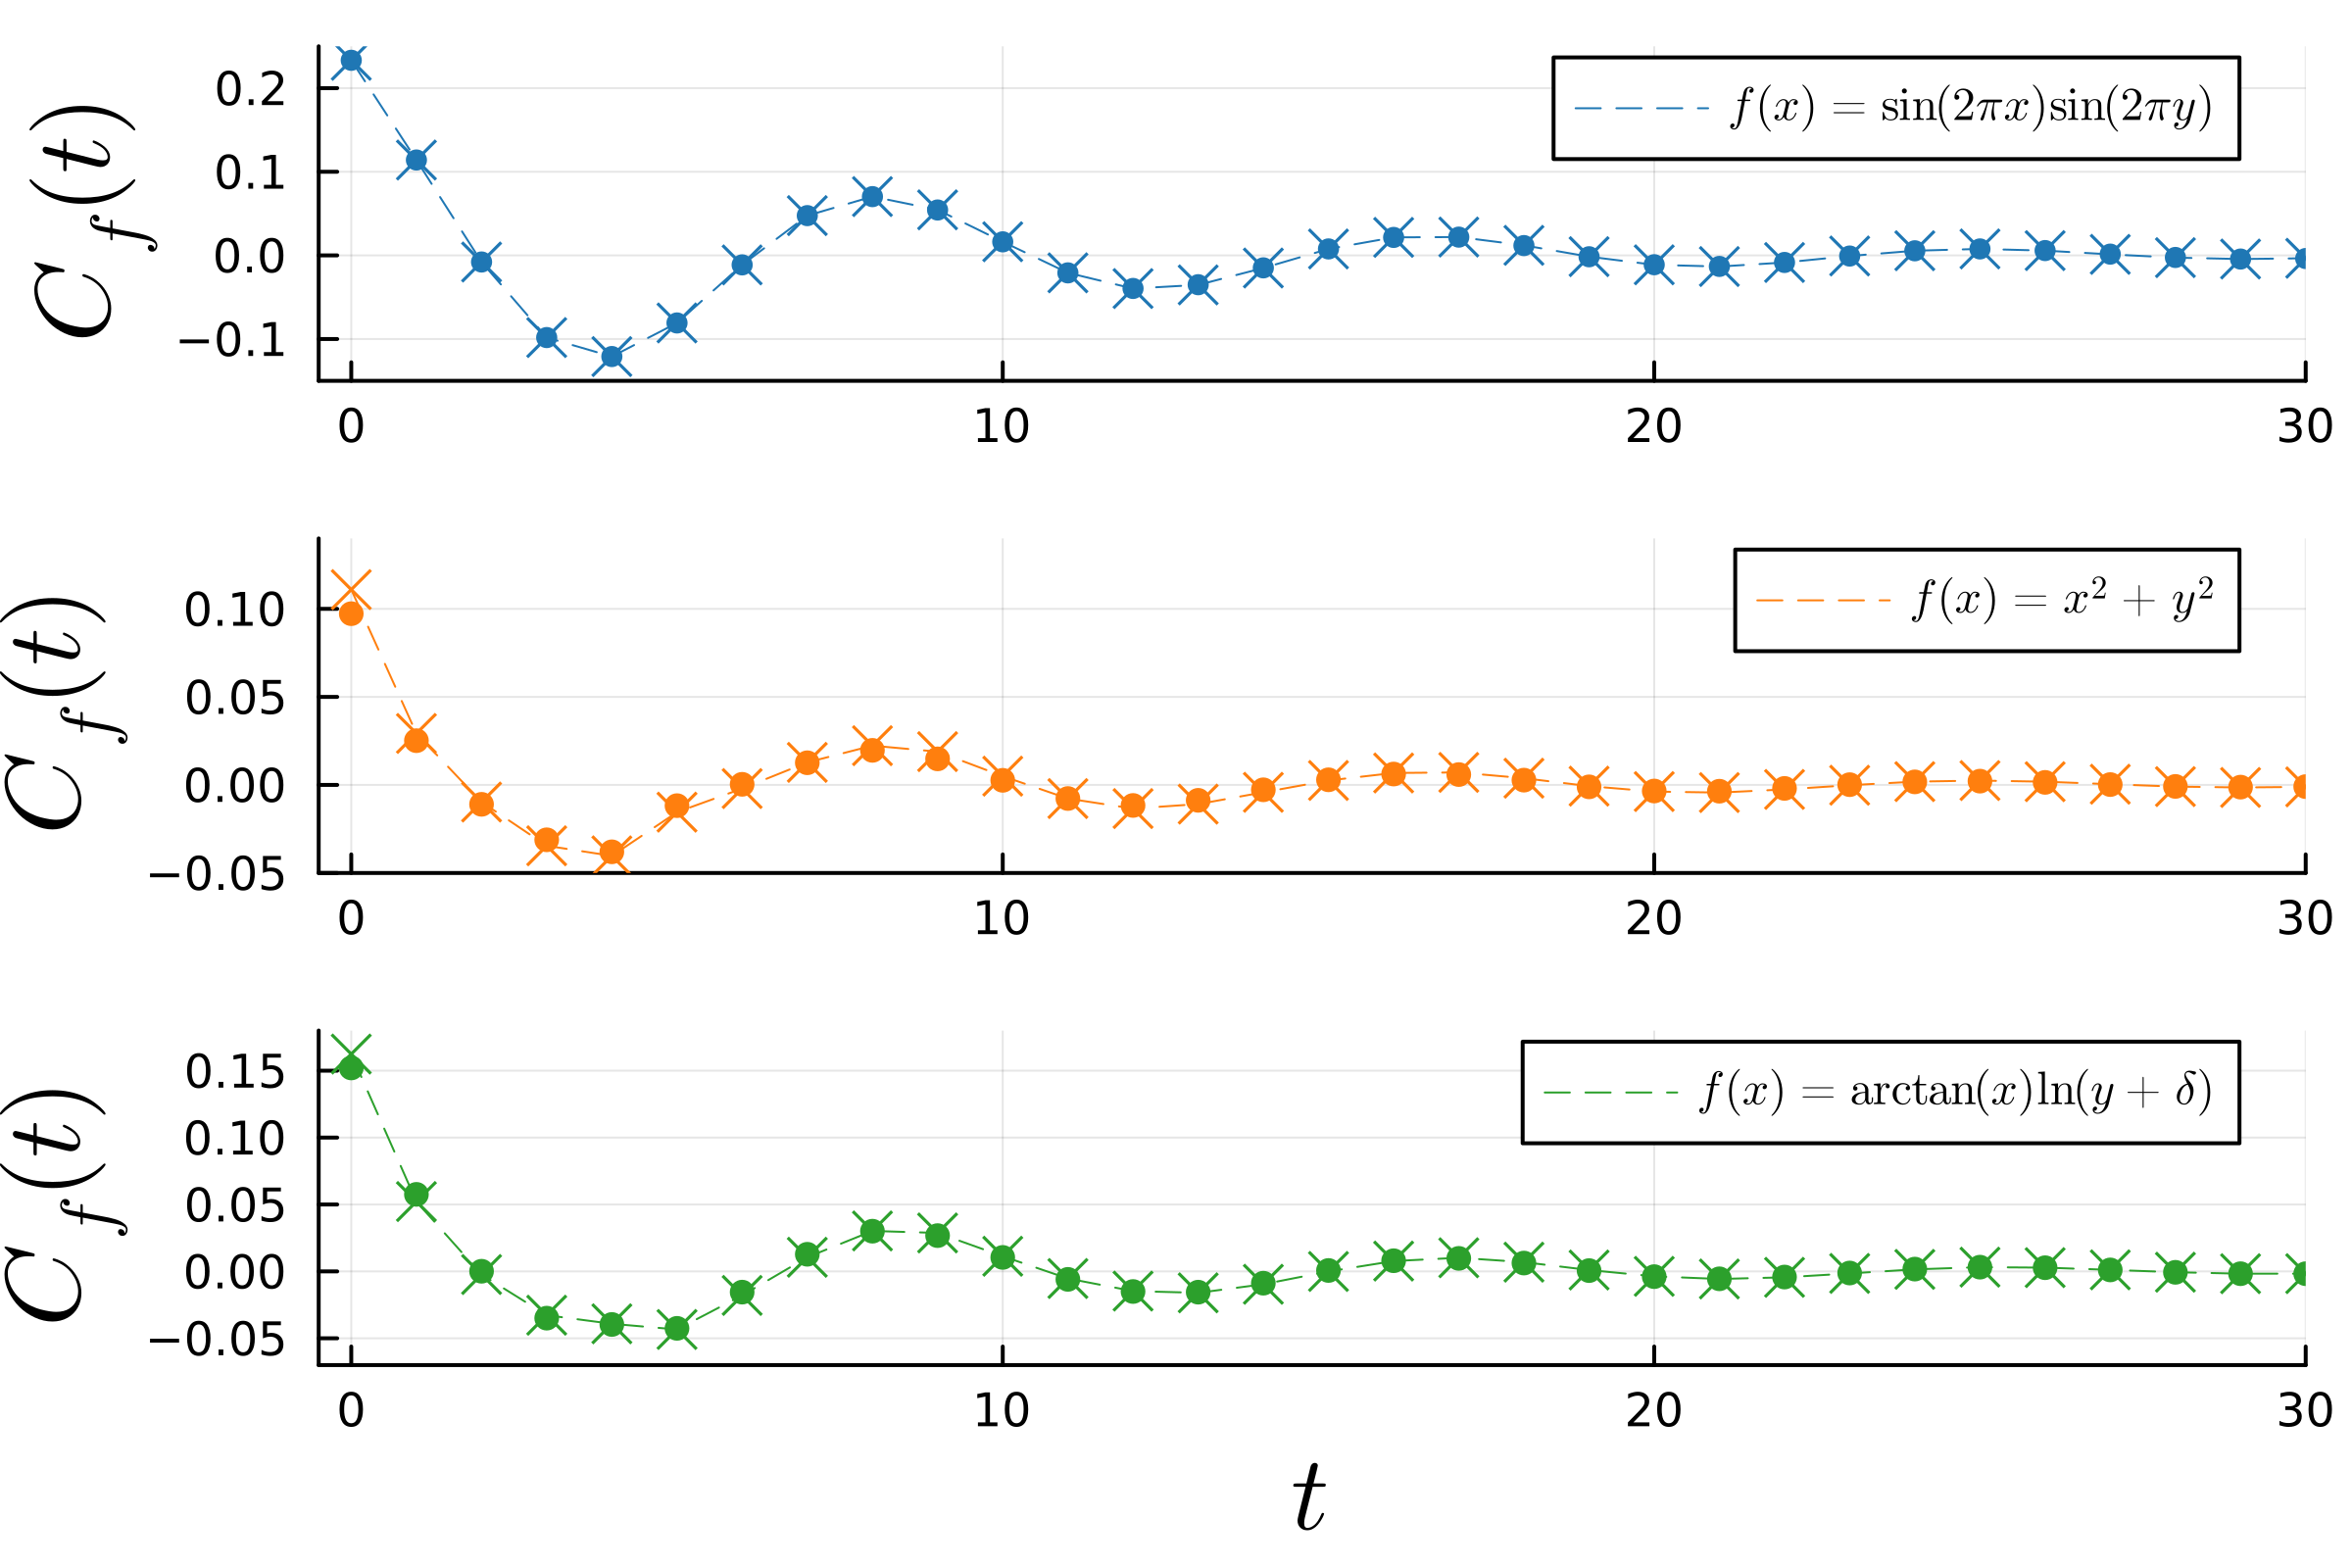

In [155]:
lags = 0:40

# FIRST OBSERVABLE
# Spectral
removed = 0
obs(u) = sin(2*π*u[1])*sin(2*π*u[2])
h = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v = W'*h;
S(t) = Spectral_Corr(v,v,λ,Δ,t,removed)
# Numerical 
Observable = sin.(2*π*X[:,1]) .* sin.(2*π*X[:,2])
cf = autocov(Observable,lags;demean=true)

colors = palette(:tab10)
a = plot(lags,cf,color=colors[1],linestyle=:dash,linewidth=0.5,label=L"f(x) = \sin(2 \pi x) \sin(2\pi y)")
scatter!(lags,cf,color=colors[1],marker=:x,markersize=5,label="")
scatter!(lags,real( S.(lags) ),markershape=:circle,markersize=3,markerstrokewidth=0,label="",color=colors[1])
ylims!(-0.15,0.25)
ylabel!(L"C_f(t)",yguidefontsize=18)
# SECOND OBSERVABLE
obs(u) = u[1].^2 + u[2].^2
h = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v = W'*h;
S(t) = Spectral_Corr(v,v,λ,Δ,t,removed)
# Numerical 
Observable = X[:,1].^2 + X[:,2].^2
cf = autocov(Observable,lags;demean=true)

b = plot(lags,cf,linestyle=:dash,linewidth=0.5,color=colors[2],label=L"f(x) = x^2 +y^2")
scatter!(lags,cf,color=colors[2],marker=:x,markersize=5,label="")
scatter!(lags,real( S.(lags) ),markershape=:circle,markersize=3.5,markerstrokewidth=0,label="",color=colors[2])

ylabel!(L"C_f(t)",yguidefontsize=18)
ylims!(-0.05,0.14)
# THIRD OBSERVABLE
obs(u) = atan.(u[1]) .* log(u[2].+0.1)
h = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v = W'*h;
S(t) = Spectral_Corr(v,v,λ,Δ,t,removed)
# Numerical 
Observable = atan.(X[:,1]) .* log.(X[:,2] .+0.1)
cf = autocov(Observable,lags;demean=true)

c = plot(lags,cf,linestyle=:dash,linewidth=0.5,color=colors[3],label=L"f(x) = \arctan(x) \ln(y+δ)")
scatter!(lags,cf,color=colors[3],marker=:x,markersize=5,label="")
scatter!(lags,real( S.(lags) ),markershape=:circle,markersize=3.5,markerstrokewidth=0,label="",color=colors[3])
ylims!(-0.07,0.18)
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"C_f(t)",yguidefontsize=18)
plot(a,b,c;dpi=400,layout=@layout [a;b;c])
xlims!(-0.5,30)
#savefig("Correlation_functions_2Dmap.png")

# Linear Response

In [158]:
M = 10^8; tr = 500
p = (ν,σ,M,tr)
x0 = [0.3,0.2];
X = ArnoldMap_Integrate(x0,p);

In [159]:
# Get the invariant measure
edges = 0:0.005:1 ; dx = (edges[2] - edges[1])
xp = edges[1]  : dx : edges[end-1]
yp = edges[1]  : dx : edges[end-1]
H = fit(Histogram,(X[:,1],X[:,2]),(edges,edges),closed=:left)
H = normalize(H,mode=:pdf);
ρ0 = H.weights ;

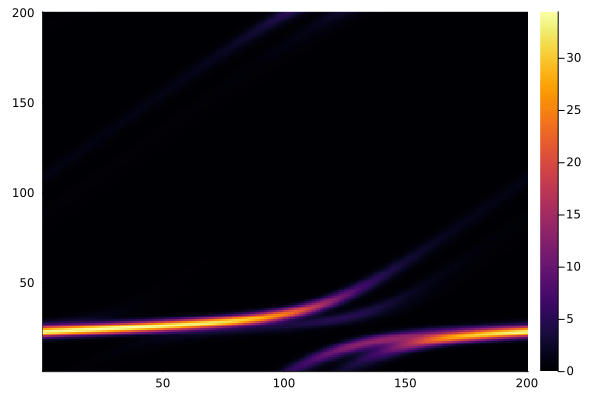

In [161]:
heatmap(transpose(ρ0))

In [162]:
G_leb =  get_Leb_scalar_prod(comb_mixed,comb_diag,N);
Δ_leb = Ξ'*G_leb*Ξ;

In [163]:
# Forcing
α = angle(ν) ; μ = abs(ν) 
Forcing_profile(u) = u[1]#sin(2*π*(u[1]-2*u[2]))#log(2+cos(2*π*u[1]))##cos(2*π*u[1])#(u[1] -1/2)^2#log(2+cos(2*π*u[1]))#sin(2*π*u[2])#sin(2*π*(u[1]-2*u[2]))#cos(2*π*u[1]) # sin(2*π*(u[1]-2*u[2]))#log(2+cos(2*π*u[1] ))#sin(2*π*(u[1]-u[2]))#cos(2*π*(u[1])) / (2+cos(2*π*(u[1]-u[2])))#1/π * sin( 2*π*(u[1]+u[2]) - α ) / ( 1 + μ^2  - 2 * μ * cos(2*π*(u[1]+u[2]) - α) )#sin(2*π*(u[1]+u[2]))#cos(2*π*u[1])#1/π * sin( 2*π*(u[1]+u[2]) - α ) / ( 1 + μ^2  - 2 * μ * cos(2*π*(u[1]+u[2]) - α) )#
FNum = zeros(length(xp),length(yp))

for i in 1:length(xp)
    for j in 1:length(yp)
        x = [xp[i],yp[j]]
        FNum[i,j] = Forcing_profile(x)
    end
end

In [165]:
γ = FNum .* ρ0
h_γ = proj_dictionary_numerical_Fourier(γ,comb_mixed,comb_diag,xp,yp);

In [166]:
h_γX , h_γY = spectral_der(h_γ,comb_mixed,comb_diag);
v_γ = W'*(h_γX +h_γY);

In [167]:
# γ_rec = reconstruct(xp,yp,h_γ,comb_mixed,comb_diag)
# heatmap(xp,yp,transpose(real(γ_rec)))

In [168]:
# Load the Numerical Green's functsion for these parameter settings
Dat = JLD2.load("Data_GreenFunctions_01_X.jld2")
amplitudes = Dat["amplitudes"]
data = Dat["Data"]

Gf = zeros(size(data[1])[1],size(data[1])[2])

for j in 1:size(data[1])[2]
    for i in 1:length(data)
        d = data[i]
        Gf[:,j] .+= d[:,j] ./ length(data) 
    end
end

┌ Warning: type Main.#return_obs does not exist in workspace; reconstructing
└ @ JLD2 /Users/niccolo/.julia/packages/JLD2/z3MOM/src/data/reconstructing_datatypes.jl:492


In [169]:
obs(u) = sin(2*π*sum(u))
hObs = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v1 = W'*hObs;

obs(u) = cos(2*π*sum(u))
hObs = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v2 = W'*hObs;

obs(u) = sin(2*π*u[1])*cos(2*π*u[2])
hObs = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v3 = W'*hObs;

obs(u) = cos(2*π*u[1])*cos(2*π*u[2])
hObs = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v4 = W'*hObs;

obs(u) = cos(2*π*u[1])*sin(6*π*u[2])
hObs = proj_dictionary_analytical_Fourier(obs,comb_mixed,comb_diag);
v5 = W'*hObs;

[-3.376606865413838e-9, -3.914828316918724e-10, -2.277124601251878e-9, -6.337368746632011e-9, -8.278111148163746e-9, -6.5717410187099315e-9, -4.231399751954492e-9, 1.141145526383527e-9, 3.1800450319229856e-9, 3.487303805021014e-9]


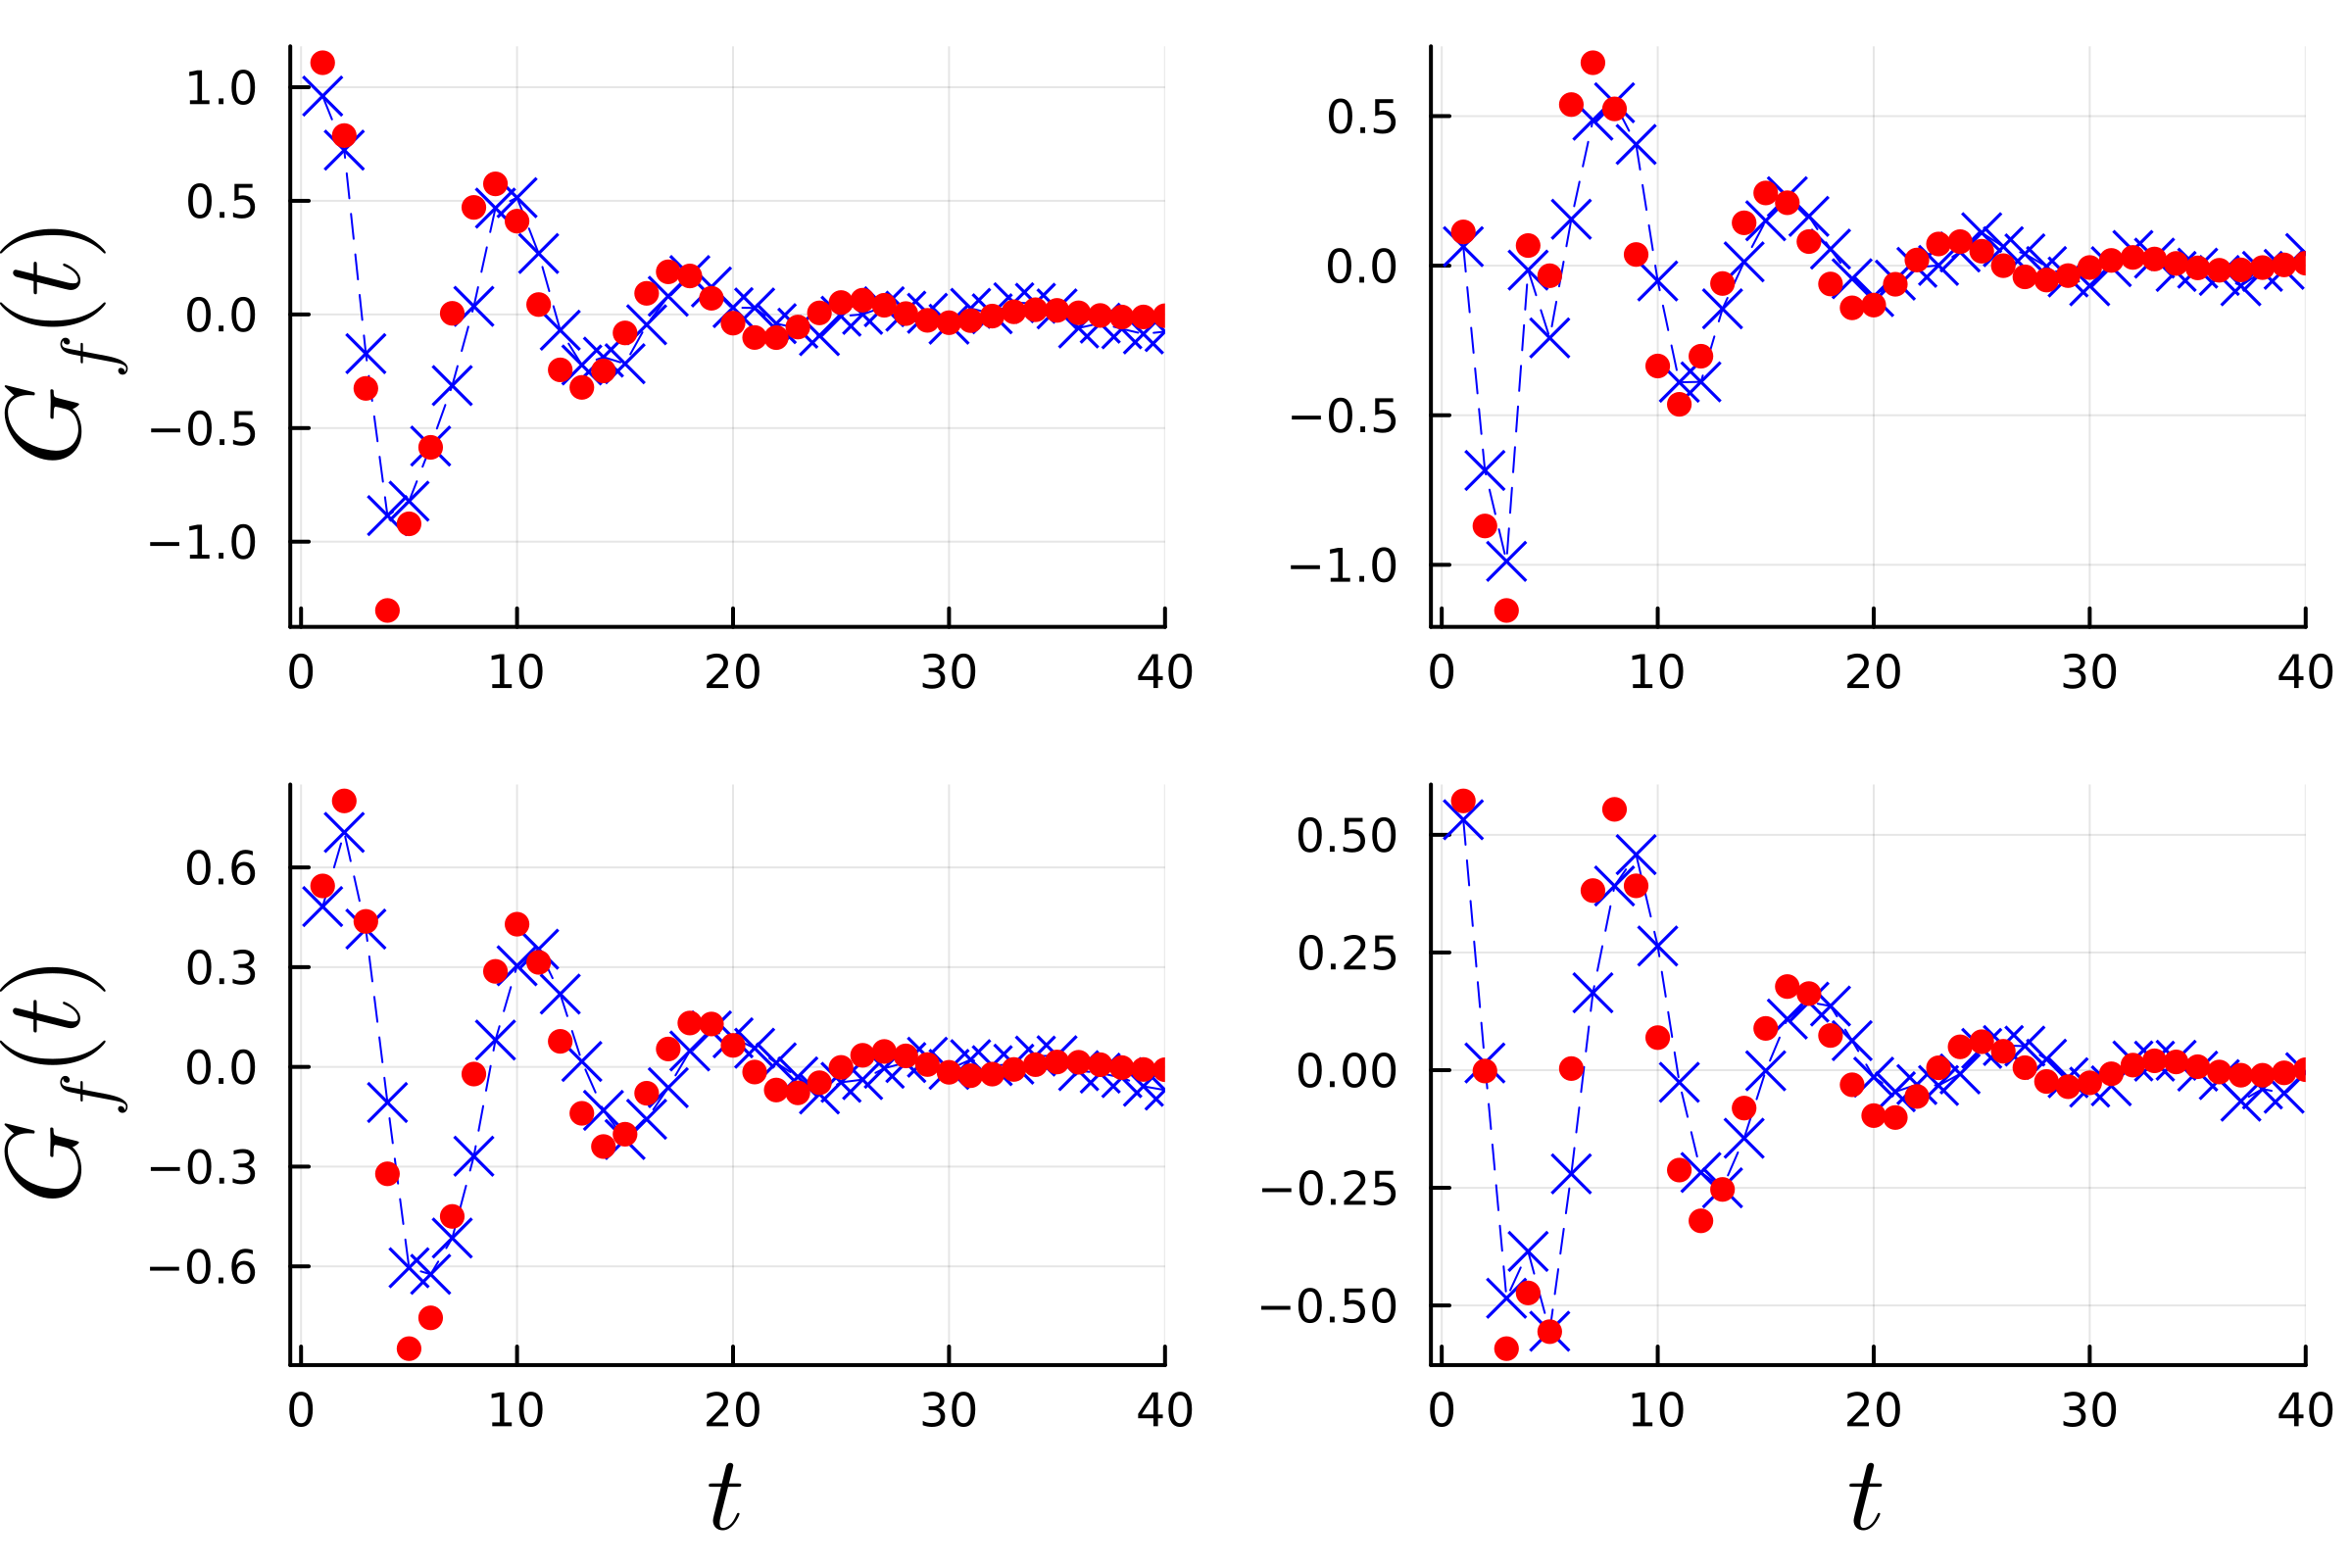

In [170]:
lags = 1:50
v_newObs = v_γ
Δ = Δ_leb
removed = 0
S(t) = Spectral_Corr(v1,v_newObs,λ,Δ,t,removed)
p1 = plot(1:size(Gf)[1],Gf[:,1],label="",color=:blue,linestyle=:dash,linewidth=0.5)
scatter!(1:size(Gf)[1],Gf[:,1],label="",color=:blue,marker=:x,markersize=5)
scatter!(lags,-real(S.(lags)),markersize=3.5,markerstrokewidth=0,label="",color=:red)
ylabel!(L"G_f(t)",yguidefontsize=18)
S(t) = Spectral_Corr(v2,v_newObs,λ,Δ,t,removed)
p2 = plot(1:size(Gf)[1],Gf[:,2],label="",color=:blue,linestyle=:dash,linewidth=0.5)
scatter!(1:size(Gf)[1],Gf[:,2],label="",color=:blue,marker=:x,markersize=5)
scatter!(lags,-real(S.(lags)),label="",markersize=3.5,markerstrokewidth=0,color=:red)
S(t) = Spectral_Corr(v3,v_newObs,λ,Δ,t,removed)
p3 = plot(1:size(Gf)[1],Gf[:,3],label="",color=:blue,linestyle=:dash,linewidth=0.5)
scatter!(1:size(Gf)[1],Gf[:,3],label="",color=:blue,marker=:x,markersize=5)
scatter!(lags,-real(S.(lags)),label="",markersize=3.5,markerstrokewidth=0,color=:red)
xlabel!(L"t",xguidefontsize=18)
ylabel!(L"G_f(t)",yguidefontsize=18)
S(t) = Spectral_Corr(v4,v_newObs,λ,Δ,t,removed)
p4 = plot(1:size(Gf)[1],Gf[:,4],label="",color=:blue,linestyle=:dash,linewidth=0.5)
scatter!(1:size(Gf)[1],Gf[:,4],label="",color=:blue,marker=:x,markersize=5)
scatter!(lags,-real(S.(lags)),label="",markersize=3.5,markerstrokewidth=0,color=:red)
xlabel!(L"t",xguidefontsize=18)
# S(t) = Spectral_Corr(v5,v_newObs,λ,Δ,t,removed)
# p5 = plot(1:size(Gf)[1],Gf[:,5],label="")
# plot!(lags,-real(S.(lags)),label="")

println(imag(S.(1:10)))
plot(p1,p2,p3,p4,dpi = 400,layout=@layout [a b;c d])
xlims!(-0.5,40)
#ylims!(-0.5,0.5)
#savefig("GreenFunction_sinX_minus2Y_K8_2e5.png")